<a href="https://colab.research.google.com/github/Teodosiodg2002/Analisis-Datos-Medicos-Urgencias/blob/main/AnalisisDatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica: Análisis de datos medicos

## Objetivos de la práctica
1. Comprender la estructura de los datasets
2. Aprender a realizar uniones (merge) entre tablas de un dataset real.
3. Procesar variables relevantes (limpieza, transformación, resumen).
4. Convertir códigos de diagnóstico ICD en texto descriptivo.
5. Realizar un pequeño análisis exploratorio y comentar hallazgos.

### Requisitos
- Python 3.8+
- pandas, matplotlib, icd10 (instalable vía pip)
- Archivos .csv.gz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1️⃣ Cargar los datasets
Descarga los siguientes archivos y colócalos en una carpeta local (por ejemplo `./datos/`):
- edstays.csv.gz
- diagnosis.csv.gz
- triage.csv.gz
- vitalsign.csv.gz
- pyxis.csv
- medrecon.csv

Ejecuta el siguiente bloque para cargarlos en pandas.

In [ ]:
from pathlib import Path
import pandas as pd


DATA_DIR = Path('/content/drive/MyDrive/datos/')
df_edstays = pd.read_csv(DATA_DIR / 'edstays.csv.gz')
df_diagnosis = pd.read_csv(DATA_DIR / 'diagnosis.csv.gz')
df_triage = pd.read_csv(DATA_DIR / 'triage.csv.gz')
df_vitalsign = pd.read_csv(DATA_DIR / 'vitalsign.csv.gz')
df_medrecon = pd.read_csv(DATA_DIR / 'medrecon.csv')
df_pyxis = pd.read_csv(DATA_DIR / 'pyxis.csv')

print('Tamaños:')
for name, df in [('edstays', df_edstays), ('diagnosis', df_diagnosis), ('triage', df_triage), ('vitalsign', df_vitalsign) , ('medrecon', df_medrecon), ('pyxis', df_pyxis)]:
    print(name, df.shape)

Tamaños:
edstays (222, 9)
diagnosis (545, 6)
triage (222, 11)
vitalsign (1038, 11)
medrecon (2764, 9)
pyxis (1082, 7)


In [ ]:
import warnings

# Filtra específicamente las DeprecationWarning relacionadas con datetime.utcnow
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="jupyter_client"
)

print("Advertencias de 'datetime.utcnow()' suprimidas.")

Advertencias de 'datetime.utcnow()' suprimidas.


## 2️⃣ Ejemplo de *merge*
Ejemplo de unión entre `edstays` y `diagnosis` usando `stay_id`.

Tu tarea: repetir el proceso uniendo las demás tablas (`triage`, `vitalsign`).

### 🧠 Ejercicio 1
Realiza tú la fusión completa entre las cuatro tablas (`edstays`, `diagnosis`, `triage`, `vitalsign`).

Guarda el resultado en una variable llamada `df_merged`.

In [ ]:
print("\nColumnas resultantes:")
print(df_pyxis.columns.tolist())
print("\nColumnas resultantes:")
print(df_medrecon.columns.tolist())
df_medrecon.head()



Columnas resultantes:
['subject_id', 'stay_id', 'charttime', 'med_rn', 'name', 'gsn_rn', 'gsn']

Columnas resultantes:
['subject_id', 'stay_id', 'charttime', 'name', 'gsn', 'ndc', 'etc_rn', 'etccode', 'etcdescription']


,subject_id,stay_id,charttime,name,gsn,ndc,etc_rn,etccode,etcdescription
0,10023117,31283645,2171-11-07 20:38:00,*acuvite,0,0,1,NaN,NaN
1,10038999,34205403,2132-05-17 21:17:00,*depakote DR,0,0,1,NaN,NaN
2,10002428,38216551,2160-07-15 19:43:00,*nutrient drink,0,0,1,NaN,NaN
3,10016742,33335871,2178-07-22 06:08:00,*iron liquid,0,0,1,NaN,NaN
4,10040025,32034003,2143-03-10 23:20:00,amoxicillin,8996,10544054615,1,3.0,Aminopenicillin Antibiotic


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

'''
------------------------------------------------
 1. PREPARACIÓN: normalizar tipos y columnas clave
------------------------------------------------
 Motivo: trabajar con stay_id consistente y con variables numéricas donde toca.
'''

# Columnas que intentamos convertir a numéricas en triage y vitalsign.
cols_to_numeric_triage = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']
cols_to_numeric_vitals = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain']

# Explicación del 'errors="coerce"':
#  - En datos clínicos a menudo encontramos strings como 'N/A', 'unk', '--'.
#  - 'coerce' convierte esos valores a NaN, lo que nos permite calcular medias sin crash.
df_triage[cols_to_numeric_triage] = df_triage[cols_to_numeric_triage].apply(lambda s: pd.to_numeric(s, errors='coerce'))
df_vitalsign[cols_to_numeric_vitals] = df_vitalsign[cols_to_numeric_vitals].apply(lambda s: pd.to_numeric(s, errors='coerce'))

# Convertir timestamps (si existen) para poder ordenar o calcular tiempos.
if 'charttime' in df_vitalsign.columns:
    # Algunos datasets guardan 'charttime' como strings; mejor pasarlo a datetime.
    df_vitalsign['charttime'] = pd.to_datetime(df_vitalsign['charttime'], errors='coerce')


'''
--------------------------------------------------
 2. UNIR/CONCAT de triage + vitalsign => mediciones
--------------------------------------------------
 Idea: ambas tablas son "mediciones" del paciente en distintos momentos
 y con columnas que coinciden parcialmente (p.ej. temperature). Por eso
 las apilamos (concat) y luego resumimos por stay_id.
'''

triage_subset = ['stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']
vitals_subset = ['stay_id', 'charttime', 'rhythm', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain']

# Seleccionar las columnas de los DataFrames antes de concatenar
triage_subset_df = df_triage[triage_subset]
vitals_subset_df = df_vitalsign[vitals_subset]

# Apilamos. ignore_index para evitar índices duplicados raros.
all_vitals_data = pd.concat([triage_subset_df, vitals_subset_df], ignore_index=True, sort=False)


'''
--------------------------------------------------
 3. AGRUPAR mediciones => 1 fila por stay_id (resumen)
--------------------------------------------------
 Decisiones de agregación:
  - Variables fisiológicas (temp, hr, etc) -> media (representa el "valor típico")
  - Campos categóricos/texto -> 'first' o moda (para tener un texto representativo)
  - Para 'charttime' usamos la moda (hora que más aparece) porque "primero" puede ser triage vs ingreso.

 Definimos una función para la MODA
 Esta función calcula la moda (.mode()) y, si existe, devuelve el primer
 valor ([0]). Si la columna está vacía (solo NaN), devuelve NaN.
'''

def get_mode(x):
    m = x.dropna().mode()
    if not m.empty:
        return m.iloc[0]
    return np.nan

# Construcción del diccionario de agregación
# - medias para numéricos
# - Para textos/categorías queremos el 'primero' que aparezca o la moda

agg_rules_vitals = {
    'temperature': 'mean',
    'heartrate': 'mean',
    'resprate': 'mean',
    'o2sat': 'mean',
    'sbp': 'mean',
    'dbp': 'mean',
    'pain': 'mean',
    'acuity': 'mean',        # 'acuity' solo está en triage, así que la media será su propio valor.
    'chiefcomplaint': 'first', # 'first' ignora los NaN y coge el primer texto que encuentra.
    'charttime': get_mode,
    'rhythm': get_mode

}

# Aplicamos las reglas de agrupación.
vitals_summary = (
    all_vitals_data
    .groupby('stay_id', dropna=False)
    .agg(agg_rules_vitals)
    .reset_index()
)

'''
--------------------------------------------------
 4. AGRUPAR DIAGNÓSTICOS (df_diagnosis)
--------------------------------------------------
 Queremos UNA fila por stay_id con:
  - lista de códigos ICD únicos
  - lista de títulos únicos
  - número de diagnósticos
  - versión ICD (si procede).
'''
diag_summary = (
    df_diagnosis
    .groupby('stay_id', dropna=False)
    .agg(
        all_icd_codes=('icd_code', lambda x: ', '.join(sorted(set(x.dropna().astype(str))))),
        all_icd_titles=('icd_title', lambda x: ' | '.join(sorted(set(x.dropna().astype(str))))),
        num_diagnoses=('seq_num', 'count'),
        icd_version=('icd_version', 'first')
    )
    .reset_index()
)

'''
--------------------------------------------------
 5. MEDICAMENTOS: apilar pyxis + medrecon y agrupar
--------------------------------------------------
 Seleccionamos columnas útiles: 'name' y 'etcdescription' (clase/categoría).

 *** EXPLICACIÓN DE POR QUÉ OMITIMOS COLUMNAS ***

 1. ¿Por qué OMITIMOS 'med_rn', 'gsn_rn', 'etc_rn'?
    - El sufijo '_rn' significa "Row Number" (Número de Fila).
    - No tienen NINGÚN valor médico o analítico. Si calculamos la 'media' o
      'moda' de 'med_rn', el resultado no significaría nada.

 2. ¿Por qué OMITIMOS 'gsn', 'ndc', 'etccode', 'charttime' (de las medicinas)?
    - 'gsn', 'ndc', 'etccode' son CÓDIGOS de fármacos. Son redundantes.
      Es más útil tener el NOMBRE ('name') y la CLASE ('etcdescription').
    - 'charttime' (de las medicinas) nos dice la hora de cada dosis.

 Por lo tanto, nos quedamos SOLO con las columnas que nos dan
 características útiles:

'''
pyxis_subset = df_pyxis[['stay_id', 'name']]
medrecon_subset = df_medrecon[['stay_id', 'name', 'etcdescription']]

all_meds_data = pd.concat([pyxis_subset, medrecon_subset], ignore_index=True)

# Agrupación
meds_agrupacion = (
        all_meds_data
        .groupby('stay_id', dropna=False)
        .agg(
            all_med_names=('name', lambda x: ' | '.join(sorted(set(x.dropna().astype(str))))),
            all_med_classes=('etcdescription', lambda x: ' | '.join(sorted(set(x.dropna().astype(str))))),
            total_meds_count=('name', 'count')
        )
        .reset_index()
    )


# --------------------------------------------------
# 6. UNIÓN FINAL: edstays + diag_summary + vitals_summary + meds_agrupacion
# --------------------------------------------------
df_final = df_edstays.copy()

df_final = df_final.merge(diag_summary, on='stay_id', how='left')
df_final = df_final.merge(vitals_summary, on='stay_id', how='left')
df_final = df_final.merge(meds_agrupacion, on='stay_id', how='left')

# --------------------------------------------------
# 7. LIMPIEZA FINAL y checks ligeros
# --------------------------------------------------
# Eliminar columnas redundantes si existen

df_final = df_final.drop(columns=['subject_id', 'hadm_id'])

# --- 8. VERIFICACIÓN ---
print(f"Forma final de la tabla: {df_final.shape}")
print("\nColumnas resultantes:")
print(df_final.columns.tolist())
df_final.head()

#intime outtime -> Cononer tiempo de estancia en el hopital y temporada invierno, verano, otro
#gender, arrival_transport, disposition -> Convertirlo a 0 o 1


Forma final de la tabla: (222, 25)

Columnas resultantes:
['stay_id', 'intime', 'outtime', 'gender', 'race', 'arrival_transport', 'disposition', 'all_icd_codes', 'all_icd_titles', 'num_diagnoses', 'icd_version', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint', 'charttime', 'rhythm', 'all_med_names', 'all_med_classes', 'total_meds_count']


,stay_id,intime,outtime,gender,race,arrival_transport,disposition,all_icd_codes,all_icd_titles,num_diagnoses,...,sbp,dbp,pain,acuity,chiefcomplaint,charttime,rhythm,all_med_names,all_med_classes,total_meds_count
0,37887480,2125-03-19 12:36:00,2125-03-19 16:59:47,F,WHITE - OTHER EUROPEAN,WALK IN,ADMITTED,"0389, 78552, 99592, E9479",ADV EFF MEDICINAL NOS | SEPTIC SHOCK | SEPTICE...,4.0,...,111.833333,66.166667,3.750000,1.0,FEVER,2125-03-19 13:07:00,Sinus Tachycardia,CefePIME | HYDROmorphone (Dilaudid) | Lorazepa...,Analgesic Opioid Agonists | Contraceptive Oral...,14.0
1,34176810,2154-02-05 17:09:00,2154-02-05 22:54:00,F,WHITE,AMBULANCE,ADMITTED,R55,Syncope and collapse,1.0,...,148.000000,62.333333,1.333333,2.0,"Syncope, Transfer",2154-02-05 17:11:00,NaN,Vitamin D3 | aspirin | atenolol | enalapril ma...,ACE Inhibitors | Antihyperlipidemic - HMG CoA ...,7.0
2,32103106,2154-08-03 15:31:00,2154-08-03 22:29:00,F,WHITE,AMBULANCE,HOME,H9312,"Tinnitus, left ear",1.0,...,138.750000,73.500000,0.000000,2.0,"N/V, Tinnitus",2154-08-03 15:34:00,NaN,Bayer Aspirin | Potassium Chloride 10mEq TAB |...,ACE Inhibitors | Beta Blockers Cardiac Selecti...,10.0
3,38797992,2153-02-12 21:59:00,2153-02-13 01:38:00,F,WHITE,AMBULANCE,ADMITTED,"25000, 2761, 29410, 3310, 486",ALZHEIMER'S DISEASE | DEMENTIA IN CONDITIONS C...,5.0,...,113.200000,76.000000,0.000000,1.0,SOB/ABNL LABS,2153-02-12 22:32:00,NaN,Acetaminophen (Rectal) | Celexa | Colace | Lan...,Analgesic Opioid Hydrocodone Combinations | An...,17.0
4,33473053,2137-06-12 16:54:00,2137-06-12 18:37:22,F,WHITE,AMBULANCE,ADMITTED,I2699,Other pulmonary embolism without acute cor pul...,1.0,...,95.000000,61.166667,0.000000,2.0,PE,2137-06-12 16:55:00,NaN,Heparin Sodium | metoprolol tartrate,Beta Blockers Cardiac Selective,3.0


## 3️⃣ Procesamiento de variables
Ejemplo de procesamiento de variables continuas y categóricas.

### 🧠 Ejercicio 2
Selecciona entre 1 y 3 variables adicionales (por ejemplo: `heartrate`, `bloodpressure`, `gender`, `triagecategory`) y realiza:
1. Limpieza de valores nulos o atípicos.
2. Visualización básica (histograma, boxplot o conteo de categorías).
3. Breve comentario sobre lo que observas.

Número de nulos en 'heartrate': 10
Número de outliers detectados en 'heartrate': 0
Conteo de 'rhythm' (moda):
rhythm
NaN                    205
Sinus Rhythm             6
Sinus Tachycardia        3
Atrial Fibrillation      3
Normal Sinus Rhythm      2
Paced Rhythm             2
afib                     1
Name: count, dtype: int64
Número de nulos en 'sbp': 10
Número de outliers detectados en 'sbp': 4


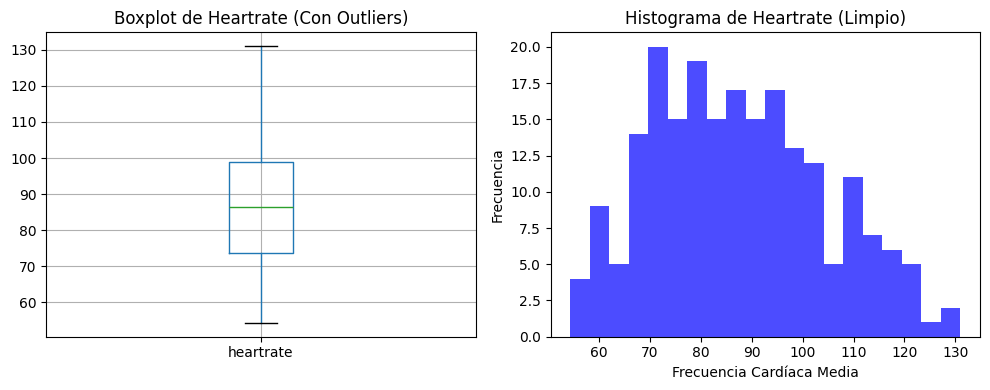

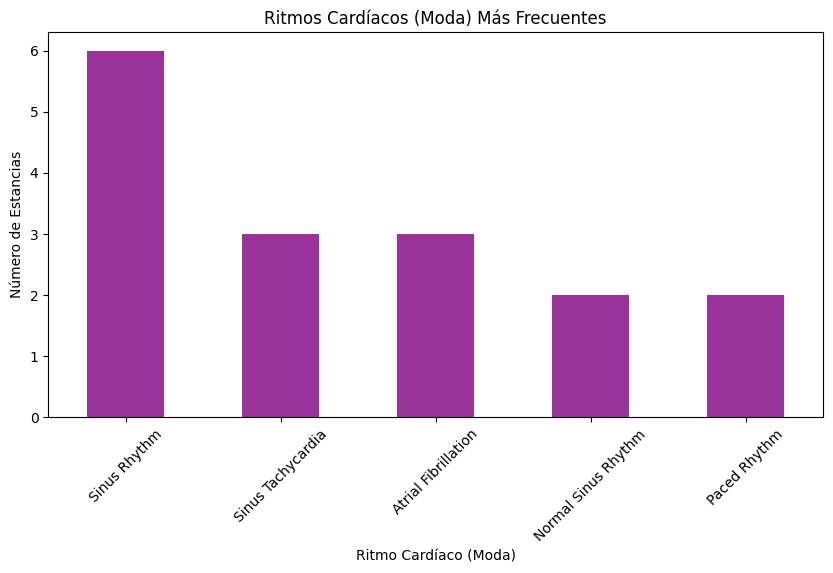

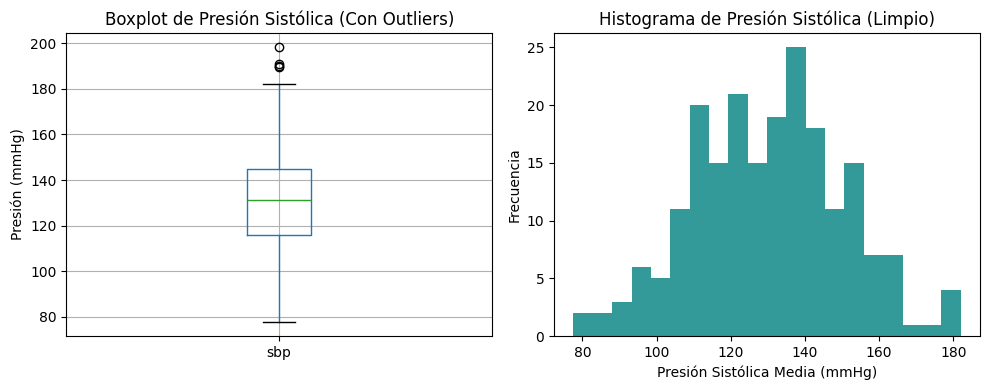

In [ ]:
import matplotlib.pyplot as plt

def detect_outliers_iqr(df_in, features, k=1.5):
    out_idx = set()
    for col in features:
        Q1 = df_in[col].quantile(0.25)
        Q3 = df_in[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        ids = df_in[(df_in[col] < lower) | (df_in[col] > upper)].index
        out_idx.update(ids.tolist())
    return sorted(list(out_idx))

# -------------
# heartrate (Frecuencia Cardíaca Media)
# -------------

# Voy a analizar la columna heartrate que creamos (la media de todas las mediciones).

# --- Limpieza de Nulos ---
null_count = df_final['heartrate'].isnull().sum()
print(f"Número de nulos en 'heartrate': {null_count}")

# Para el análisis, creamos un df temporal sin esos nulos
df_analysis = df_final.dropna(subset=['heartrate'])

# --- Detección de Atípicos ---
outlier_indices = detect_outliers_iqr(df_analysis, ['heartrate'])
print(f"Número de outliers detectados en 'heartrate': {len(outlier_indices)}")

# Creamos un DataFrame LIMPIO (sin outliers) para comparar
df_clean_hr = df_analysis.drop(outlier_indices)

# -------------
# rhythm
# -------------

# --- 1. Conteo de categorías ---
# Usamos .value_counts() para contar cada ritmo único.
# Usamos dropna=False para que también cuente los 'NaN' (nulos).

print("Conteo de 'rhythm' (moda):")
print(df_final['rhythm'].value_counts(dropna=False).head(10))

# Para la visualización, es más limpio tomar los 10 ritmos más
# comunes, excluyendo los nulos (por eso no ponemos dropna=False aquí).

top_rhythms = df_final['rhythm'].value_counts().head()

# -------------
# sbp (Presión Arterial Sistólica)
# -------------

# --- 1. Limpieza de Nulos ---
null_count_sbp = df_final['sbp'].isnull().sum()
print(f"Número de nulos en 'sbp': {null_count_sbp}")

df_analysis_sbp = df_final.dropna(subset=['sbp'])

# --- 2. Detección de Atípicos ---
outlier_indices_sbp = detect_outliers_iqr(df_analysis_sbp, ['sbp'])
print(f"Número de outliers detectados en 'sbp': {len(outlier_indices_sbp)}")

# --- 3. Creación del DataFrame Limpio ---
df_clean_sbp = df_analysis_sbp.drop(outlier_indices_sbp)


# -------------
# Visualización
# -------------

# -------------
# heartrate (Frecuencia Cardíaca Media)
# -------------

# 1. Boxplot (CON outliers)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, 1er gráfico
df_analysis[['heartrate']].boxplot()
plt.title('Boxplot de Heartrate (Con Outliers)')

# 2. Histograma (SIN outliers)
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, 2º gráfico
plt.hist(df_clean_hr['heartrate'], bins=20, color='blue', alpha=0.7)
plt.title('Histograma de Heartrate (Limpio)')
plt.xlabel('Frecuencia Cardíaca Media')
plt.ylabel('Frecuencia')

plt.tight_layout() # Ajusta los gráficos
plt.show()

# -------------
# rhythm
# -------------

plt.figure(figsize=(10, 5)) # Damos un tamaño cómodo al gráfico
top_rhythms.plot(kind='bar', color='purple', alpha=0.8)

plt.title('Ritmos Cardíacos (Moda) Más Frecuentes')
plt.ylabel('Número de Estancias')
plt.xlabel('Ritmo Cardíaco (Moda)')
plt.xticks(rotation=45) # Rotamos las etiquetas del eje X para que se lean
plt.show()

# -------------
# sbp (Presión Arterial Sistólica)
# -------------
plt.figure(figsize=(10, 4)) # Tamaño de la figura

# 1. Boxplot (CON outliers)
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, 1er gráfico
df_analysis_sbp[['sbp']].boxplot()
plt.title('Boxplot de Presión Sistólica (Con Outliers)')
plt.ylabel('Presión (mmHg)')

# 2. Histograma (SIN outliers)
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, 2º gráfico
plt.hist(df_clean_sbp['sbp'], bins=20, color='teal', alpha=0.8)
plt.title('Histograma de Presión Sistólica (Limpio)')
plt.xlabel('Presión Sistólica Media (mmHg)')
plt.ylabel('Frecuencia')

plt.tight_layout() # Ajusta los gráficos
plt.show()


## 4️⃣ Conversión de diagnósticos ICD a texto
Ejemplo de conversión de códigos ICD a texto usando el paquete `icd10`.

**Tu tarea:** aplicar este procedimiento a los diagnósticos de tu `df_merged`.

In [ ]:
!pip install simple-icd-10


In [ ]:
import simple_icd_10 as icd
import matplotlib.pyplot as plt

icd.get_description("R55")

def icd_to_text(icd_string):
    # Primero nos aseguramos de que sea un string y no un 'NaN'
    if not isinstance(icd_string, str):
        return None

    # Partimos el string por la coma y el espacio
    codes = icd_string.split(', ')

    descriptions = []
    for code in codes:
        try:
            desc = icd.get_description(code)
            descriptions.append(desc)
        except:
            # Si un código no se encuentra, simplemente añadimos 'Código desconocido'
            descriptions.append(f"Código desconocido ({code})")

    # Unimos todas las descripciones con un " | "
    return ' | '.join(descriptions)


if 'all_icd_codes' in df_final.columns:
    df_final['all_icd_titles_full'] = df_final['all_icd_codes'].apply(icd_to_text)

    print(df_final[['all_icd_codes', 'all_icd_titles_full']].head())
else:
    print("Error: La columna 'all_icd_codes' no se encontró en df_final.")

                   all_icd_codes  \
0      0389, 78552, 99592, E9479   
1                            R55   
2                          H9312   
3  25000, 2761, 29410, 3310, 486   
4                          I2699   

                                 all_icd_titles_full  
0  Código desconocido (0389) | Código desconocido...  
1                               Syncope and collapse  
2                         Código desconocido (H9312)  
3  Código desconocido (25000) | Código desconocid...  
4                         Código desconocido (I2699)  


### 🧠 Ejercicio 3
Convierte los diagnósticos ICD de tu `df_merged` a texto descriptivo y analiza:
- Cuáles son los diagnósticos más frecuentes.
- Qué categorías clínicas predominan.


--- Diagnósticos Individuales Más Frecuentes ---
icd_title
HYPERTENSION NOS                                  21
Long term (current) use of insulin                19
Essential (primary) hypertension                  13
DIABETES UNCOMPL ADULT                            12
Type 2 diabetes mellitus without complications     9
Chest pain, unspecified                            8
HYPERCHOLESTEROLEMIA                               7
Acute kidney failure, unspecified                  7
CONGESTIVE HEART FAILURE, UNSPEC                   6
ALTERED MENTAL STATUS                              6
Dyspnea, unspecified                               6
Weakness                                           6
Urinary tract infection, site not specified        6
Unspecified atrial fibrillation                    6
ACUTE KIDNEY FAILURE, UNSPECIFIED                  6
Name: count, dtype: int64


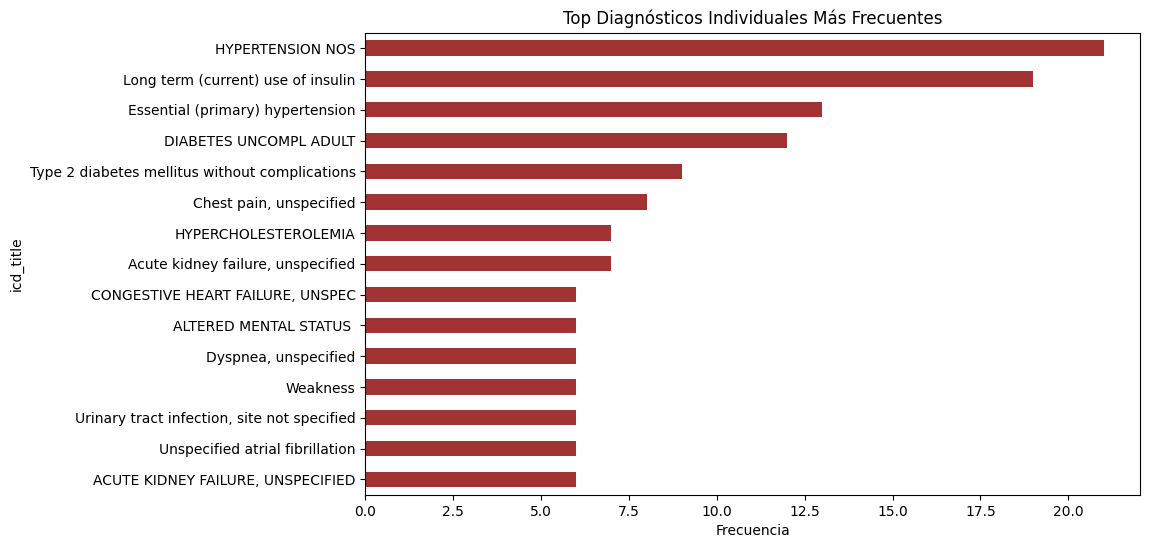

In [ ]:
# Usamos LA TABLA ORIGINAL 'df_diagnosis' para esto
if 'icd_title' in df_diagnosis.columns:
    print("\n--- Diagnósticos Individuales Más Frecuentes ---")

    # Contamos los títulos de diagnóstico más comunes
    top_diagnoses = df_diagnosis['icd_title'].value_counts().head(15)

    print(top_diagnoses)

    # Visualización
    plt.figure(figsize=(10, 6))
    top_diagnoses.plot(kind='barh', color='darkred', alpha=0.8) # barh = barras horizontales
    plt.title('Top Diagnósticos Individuales Más Frecuentes')
    plt.xlabel('Frecuencia')
    plt.gca().invert_yaxis()
    plt.show()

# Clustering

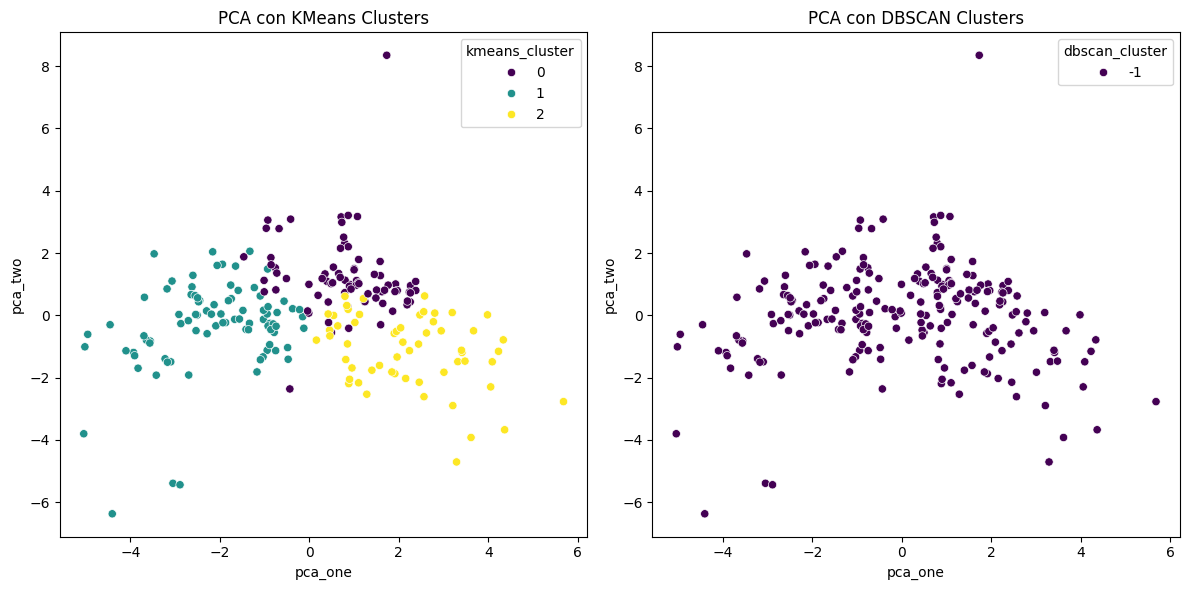

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


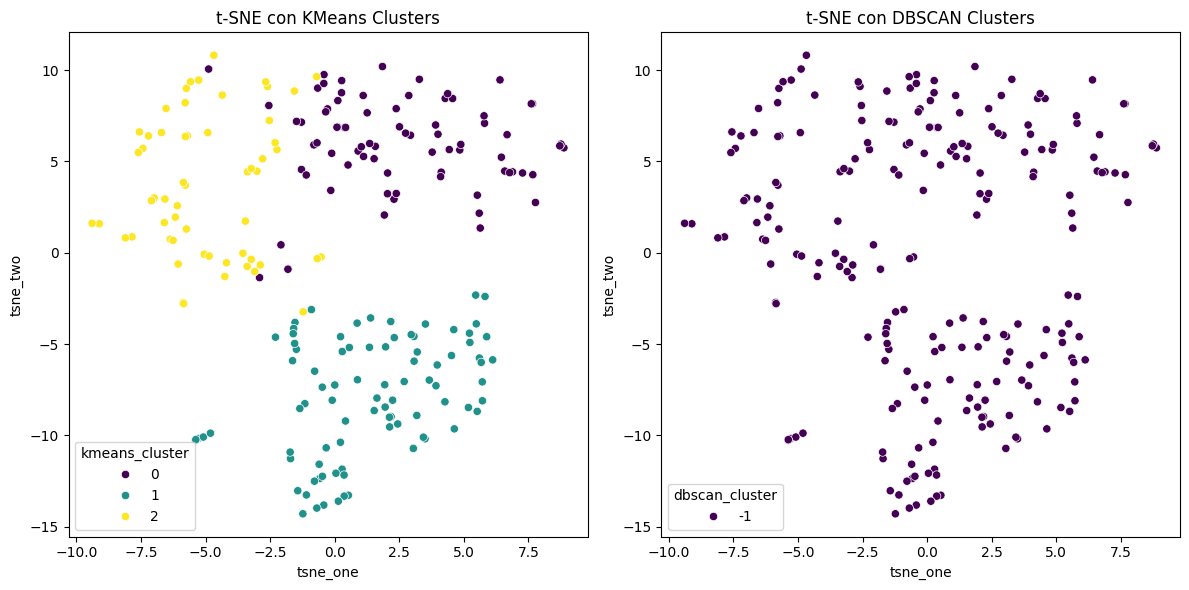

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.impute import SimpleImputer

# Seleccionar solo columnas numéricas para clustering
# Excluir stay_id y hadm_id ya que son identificadores
numeric_cols = df_final.select_dtypes(include=np.number).columns.tolist()
cols_to_exclude = ['stay_id', 'hadm_id', 'all_icd_codes', 'charttime', 'all_med_names', 'all_med_classes']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# Crear un sub-dataframe con solo las columnas numéricas seleccionadas
merged_numeric = df_final[numeric_cols].copy()

# Manejar valores faltantes para clustering (imputación con la media)
# Puedes elegir otra estrategia de imputación si es necesario
imputer = SimpleImputer(strategy='mean')
merged_numeric_imputed = imputer.fit_transform(merged_numeric)
merged_numeric_imputed_df = pd.DataFrame(merged_numeric_imputed, columns=numeric_cols)


# Escalar los datos numéricos imputados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_numeric_imputed_df)
scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols)

# Aplicar KMeans
# Se puede experimentar con diferentes números de clusters (n_clusters)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_final['kmeans_cluster'] = kmeans.fit_predict(scaled_data)

# Aplicar DBSCAN
# Se deben ajustar los parámetros eps y min_samples
dbscan = DBSCAN(eps=0.1, min_samples=3)
df_final['dbscan_cluster'] = dbscan.fit_predict(scaled_data)


# Visualización con PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
df_final['pca_one'] = pca_result[:,0]
df_final['pca_two'] = pca_result[:,1]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='pca_one', y='pca_two', hue='kmeans_cluster', data=df_final, palette='viridis')
plt.title('PCA con KMeans Clusters')

plt.subplot(1, 2, 2)
sns.scatterplot(x='pca_one', y='pca_two', hue='dbscan_cluster', data=df_final, palette='viridis')
plt.title('PCA con DBSCAN Clusters')

plt.tight_layout()
plt.show()

# Visualización con t-SNE
# t-SNE es computacionalmente más costoso y es mejor aplicarlo a un número menor de componentes de PCA
# o directamente a los datos escalados si el dataset no es muy grande.
# Usaremos los datos escalados directamente aquí.
# Se pueden ajustar los parámetros n_components (usualmente 2 o 3)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(scaled_data)
df_final['tsne_one'] = tsne_result[:,0]
df_final['tsne_two'] = tsne_result[:,1]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='tsne_one', y='tsne_two', hue='kmeans_cluster', data=df_final, palette='viridis')
plt.title('t-SNE con KMeans Clusters')

plt.subplot(1, 2, 2)
sns.scatterplot(x='tsne_one', y='tsne_two', hue='dbscan_cluster', data=df_final, palette='viridis')
plt.title('t-SNE con DBSCAN Clusters')

plt.tight_layout()
plt.show()

# Reglas de asociación

In [ ]:
# subir soporte 0.6 y vamos bajandolo poquito a poco
